In [5]:
!pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.7 MB 8.7 MB/s eta 0:00:01
   ---------------------------- ----------- 6.3/8.7 MB 18.6 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 17.8 MB/s eta 0:00:00
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Demonstrating correlation analysis...
Computing correlation matrix...
Preparing data for correlation analysis...
Total pixels: 683,064
Valid pixels: 630,024 (92.2%)
Computing pearson correlation matrix...
Correlation matrix computed successfully!


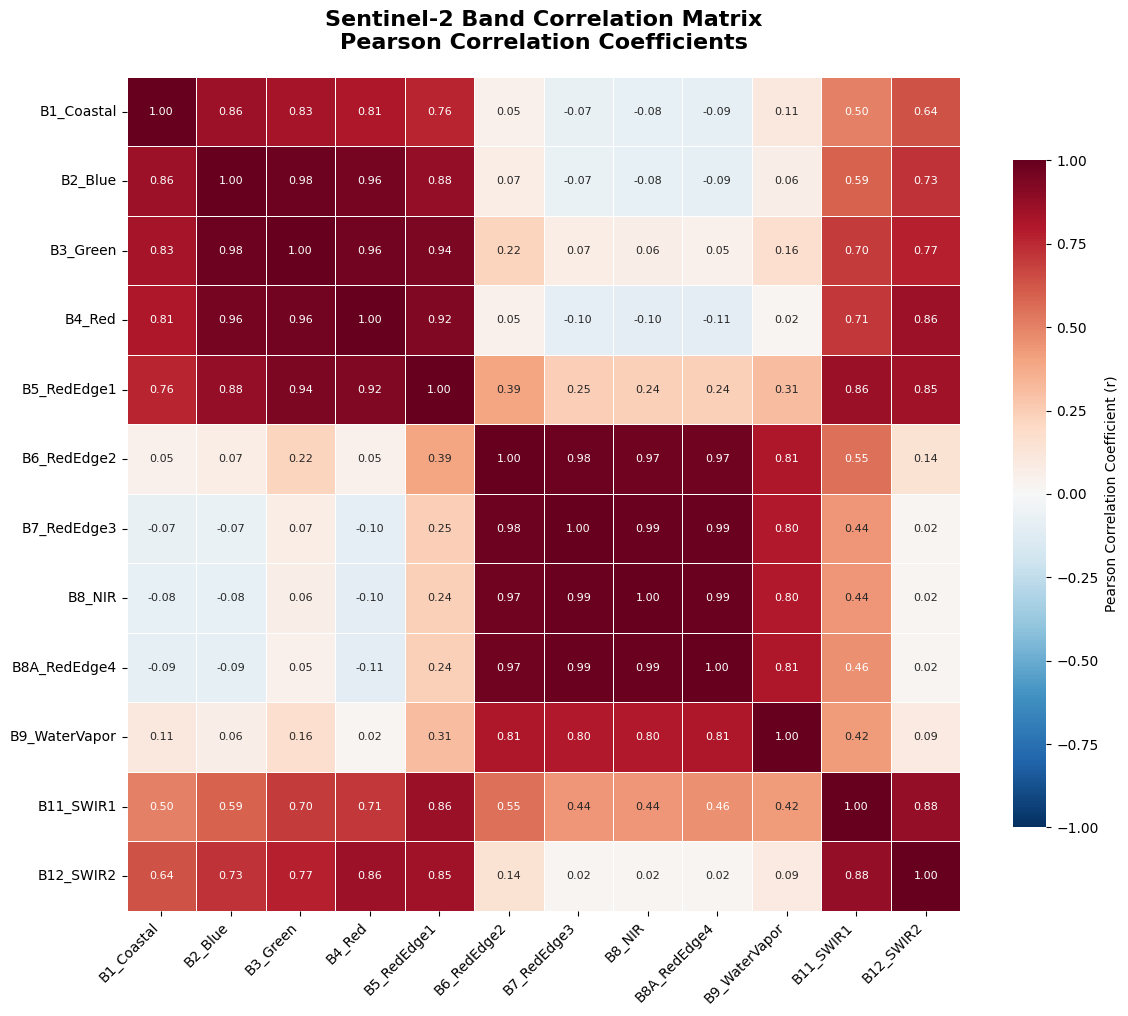


CORRELATION MATRIX ANALYSIS

1. MATRIX PROPERTIES:
--------------------
   • Shape: (12, 12)
   • Type: Symmetric
   • Diagonal elements: All ones
   • Value range: [-0.109, 1.000]
   • Positive semi-definite: Yes
   • Condition number: 1533.24

   MATHEMATICAL CLASSIFICATION:
   → This is a SYMMETRIC, POSITIVE SEMI-DEFINITE matrix
   → Diagonal elements = 1 (perfect self-correlation)
   → Off-diagonal: correlation between different bands

2. CORRELATION STATISTICS:
-------------------------
   • Mean correlation: 0.459
   • Standard deviation: 0.395
   • Range: [-0.109, 0.992]

3. HIGHLY CORRELATED BANDS (|r| ≥ 0.8):
----------------------------------------
   • B7_RedEdge3 ↔ B8A_RedEdge4: r = 0.992
   • B8_NIR ↔ B8A_RedEdge4: r = 0.990
   • B7_RedEdge3 ↔ B8_NIR: r = 0.989
   • B6_RedEdge2 ↔ B7_RedEdge3: r = 0.980
   • B2_Blue ↔ B3_Green: r = 0.979
   • B6_RedEdge2 ↔ B8A_RedEdge4: r = 0.975
   • B6_RedEdge2 ↔ B8_NIR: r = 0.974
   • B3_Green ↔ B4_Red: r = 0.962
   • B2_Blue ↔ B4_Red: 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

def correlation_matrix(data, band_names=None, no_data_value=0, method='pearson'):


    if band_names is None:
        band_names = [
            'B1_Coastal', 'B2_Blue', 'B3_Green', 'B4_Red',
            'B5_RedEdge1', 'B6_RedEdge2', 'B7_RedEdge3', 'B8_NIR',
            'B8A_RedEdge4', 'B9_WaterVapor', 'B11_SWIR1', 'B12_SWIR2'
        ]

    n_bands = data.shape[2]

   
    print("Preparing data for correlation analysis...")

   
    reshaped_data = data.reshape(-1, n_bands)

   
    if no_data_value is not None:
        valid_mask = np.all((reshaped_data != no_data_value) &
                           (~np.isnan(reshaped_data)) &
                           (reshaped_data >= 0), axis=1)
    else:
        valid_mask = np.all(~np.isnan(reshaped_data), axis=1)

   
    valid_data = reshaped_data[valid_mask]
    valid_pixels = len(valid_data)

    print(f"Total pixels: {len(reshaped_data):,}")
    print(f"Valid pixels: {valid_pixels:,} ({valid_pixels/len(reshaped_data)*100:.1f}%)")

    if valid_pixels < 100:
        raise ValueError("Insufficient valid pixels for correlation analysis")

  
    print(f"Computing {method} correlation matrix...")

    if method == 'pearson':
        corr_matrix = np.corrcoef(valid_data.T)
    else:
       
        df_temp = pd.DataFrame(valid_data, columns=band_names[:n_bands])
        corr_matrix = df_temp.corr(method=method).values

  
    corr_df = pd.DataFrame(corr_matrix,
                          index=band_names[:n_bands],
                          columns=band_names[:n_bands])

    print("Correlation matrix computed successfully!")
    return corr_matrix, corr_df, valid_pixels

def analyze_matrix_properties(corr_matrix):

    properties = {}

   
    properties['shape'] = corr_matrix.shape
    properties['is_square'] = corr_matrix.shape[0] == corr_matrix.shape[1]
    properties['is_symmetric'] = np.allclose(corr_matrix, corr_matrix.T)

    
    properties['diagonal_values'] = np.diag(corr_matrix)
    properties['diagonal_is_ones'] = np.allclose(np.diag(corr_matrix), 1.0)

   
    properties['min_value'] = np.min(corr_matrix)
    properties['max_value'] = np.max(corr_matrix)
    properties['off_diagonal_min'] = np.min(corr_matrix[~np.eye(corr_matrix.shape[0], dtype=bool)])
    properties['off_diagonal_max'] = np.max(corr_matrix[~np.eye(corr_matrix.shape[0], dtype=bool)])

    
    eigenvalues = np.linalg.eigvals(corr_matrix)
    properties['eigenvalues'] = eigenvalues
    properties['is_positive_semidefinite'] = np.all(eigenvalues >= -1e-10)
    properties['condition_number'] = np.max(eigenvalues) / np.max([np.min(eigenvalues), 1e-10])

    return properties

def plot_correlation_matrix(corr_df, figsize=(12, 10), cmap='RdBu_r',
                           annotate=True, mask_diagonal=False):
   
    mask = None
    if mask_diagonal:
        mask = np.eye(len(corr_df), dtype=bool)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    im = sns.heatmap(corr_df,
                     mask=mask,
                     cmap=cmap,
                     center=0,
                     vmin=-1, vmax=1,
                     square=True,
                     linewidths=0.5,
                     annot=annotate,
                     fmt='.2f',
                     annot_kws={'size': 8},
                     cbar_kws={'label': 'Pearson Correlation Coefficient (r)',
                              'shrink': 0.8})
    ax.set_title('Sentinel-2 Band Correlation Matrix\nPearson Correlation Coefficients',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.grid(False)

    plt.tight_layout()
    return fig, ax

def analyze_correlations(corr_df, threshold_high=0.8, threshold_low=0.3):

    analysis = {}

    n = len(corr_df)
    mask = np.triu(np.ones((n, n)), k=1).astype(bool)
    upper_triangle = corr_df.values[mask]

    analysis['mean_correlation'] = np.mean(upper_triangle)
    analysis['std_correlation'] = np.std(upper_triangle)
    analysis['min_correlation'] = np.min(upper_triangle)
    analysis['max_correlation'] = np.max(upper_triangle)

    high_corr_pairs = []
    low_corr_pairs = []
    negative_corr_pairs = []

    for i in range(n):
        for j in range(i+1, n):
            corr_val = corr_df.iloc[i, j]
            band_i = corr_df.index[i]
            band_j = corr_df.columns[j]

            if abs(corr_val) >= threshold_high:
                high_corr_pairs.append((band_i, band_j, corr_val))
            elif abs(corr_val) <= threshold_low:
                low_corr_pairs.append((band_i, band_j, corr_val))

            if corr_val < 0:
                negative_corr_pairs.append((band_i, band_j, corr_val))

    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    low_corr_pairs.sort(key=lambda x: abs(x[2]))
    negative_corr_pairs.sort(key=lambda x: x[2])

    analysis['high_correlations'] = high_corr_pairs
    analysis['low_correlations'] = low_corr_pairs
    analysis['negative_correlations'] = negative_corr_pairs

    visible_bands = ['B2_Blue', 'B3_Green', 'B4_Red']
    nir_bands = ['B8_NIR', 'B8A_RedEdge4']
    red_edge_bands = ['B5_RedEdge1', 'B6_RedEdge2', 'B7_RedEdge3']
    swir_bands = ['B11_SWIR1', 'B12_SWIR2']

    def get_region_correlations(bands):
        if len(bands) < 2:
            return []
        correlations = []
        for i, band1 in enumerate(bands):
            for band2 in bands[i+1:]:
                if band1 in corr_df.index and band2 in corr_df.columns:
                    corr_val = corr_df.loc[band1, band2]
                    correlations.append(corr_val)
        return correlations

    analysis['visible_correlations'] = get_region_correlations(visible_bands)
    analysis['nir_correlations'] = get_region_correlations(nir_bands)
    analysis['red_edge_correlations'] = get_region_correlations(red_edge_bands)
    analysis['swir_correlations'] = get_region_correlations(swir_bands)

    return analysis

def print_correlation_analysis(analysis, matrix_properties):

    print("\n" + "=" * 80)
    print("CORRELATION MATRIX ANALYSIS")
    print("=" * 80)


    print("\n1. MATRIX PROPERTIES:")
    print("-" * 20)
    print(f"   • Shape: {matrix_properties['shape']}")
    print(f"   • Type: {'Symmetric' if matrix_properties['is_symmetric'] else 'Non-symmetric'}")
    print(f"   • Diagonal elements: {'All ones' if matrix_properties['diagonal_is_ones'] else 'Not all ones'}")
    print(f"   • Value range: [{matrix_properties['min_value']:.3f}, {matrix_properties['max_value']:.3f}]")
    print(f"   • Positive semi-definite: {'Yes' if matrix_properties['is_positive_semidefinite'] else 'No'}")
    print(f"   • Condition number: {matrix_properties['condition_number']:.2f}")

    print(f"\n   MATHEMATICAL CLASSIFICATION:")
    print(f"   → This is a SYMMETRIC, POSITIVE SEMI-DEFINITE matrix")
    print(f"   → Diagonal elements = 1 (perfect self-correlation)")
    print(f"   → Off-diagonal: correlation between different bands")


    print(f"\n2. CORRELATION STATISTICS:")
    print("-" * 25)
    print(f"   • Mean correlation: {analysis['mean_correlation']:.3f}")
    print(f"   • Standard deviation: {analysis['std_correlation']:.3f}")
    print(f"   • Range: [{analysis['min_correlation']:.3f}, {analysis['max_correlation']:.3f}]")


    print(f"\n3. HIGHLY CORRELATED BANDS (|r| ≥ 0.8):")
    print("-" * 40)
    if analysis['high_correlations']:
        for band1, band2, corr in analysis['high_correlations'][:10]:
            print(f"   • {band1} ↔ {band2}: r = {corr:.3f}")
    else:
        print("   • No correlations above 0.8 threshold")


    print(f"\n4. WEAKLY CORRELATED BANDS (|r| ≤ 0.3):")
    print("-" * 38)
    if analysis['low_correlations']:
        for band1, band2, corr in analysis['low_correlations'][:5]:
            print(f"   • {band1} ↔ {band2}: r = {corr:.3f}")
    else:
        print("   • No correlations below 0.3 threshold")


    print(f"\n5. NEGATIVE CORRELATIONS:")
    print("-" * 25)
    if analysis['negative_correlations']:
        for band1, band2, corr in analysis['negative_correlations']:
            print(f"   • {band1} ↔ {band2}: r = {corr:.3f}")
    else:
        print("   • No significant negative correlations found")


    print(f"\n6. SPECTRAL REGION CORRELATIONS:")
    print("-" * 32)

    regions = [
        ('Visible bands', analysis['visible_correlations']),
        ('Red edge bands', analysis['red_edge_correlations']),
        ('NIR bands', analysis['nir_correlations']),
        ('SWIR bands', analysis['swir_correlations'])
    ]

    for region_name, correlations in regions:
        if correlations:
            mean_corr = np.mean(correlations)
            print(f"   • {region_name}: Mean r = {mean_corr:.3f}")
        else:
            print(f"   • {region_name}: Insufficient bands for analysis")




if __name__ == "__main__":

   
    print("Demonstrating correlation analysis...")
    data = np.load('sentinel2_rochester.npy')

    print("Computing correlation matrix...")

   
    corr_matrix, corr_df, valid_pixels = correlation_matrix(data, no_data_value=0)

  
    properties = analyze_matrix_properties(corr_matrix)

   
    analysis = analyze_correlations(corr_df)

   
    fig, ax = plot_correlation_matrix(corr_df, figsize=(12, 10))
    plt.show()

   
    print_correlation_analysis(analysis, properties)

    
  

    print(f"\nCorrelation analysis complete!")
    print(f"Correlation matrix shape: {corr_matrix.shape}")
    print(f"Valid pixels used: {valid_pixels:,}")

In [ ]:
###part 2

Demonstrating 10m band correlation analysis...
Creating correlation and density plots...
Extracting 10-meter bands...
Total pixels: 683,064
Valid pixels: 630,024 (92.2%)
Sampling 30,000 pixels for visualization

Analyzing spectral patterns...


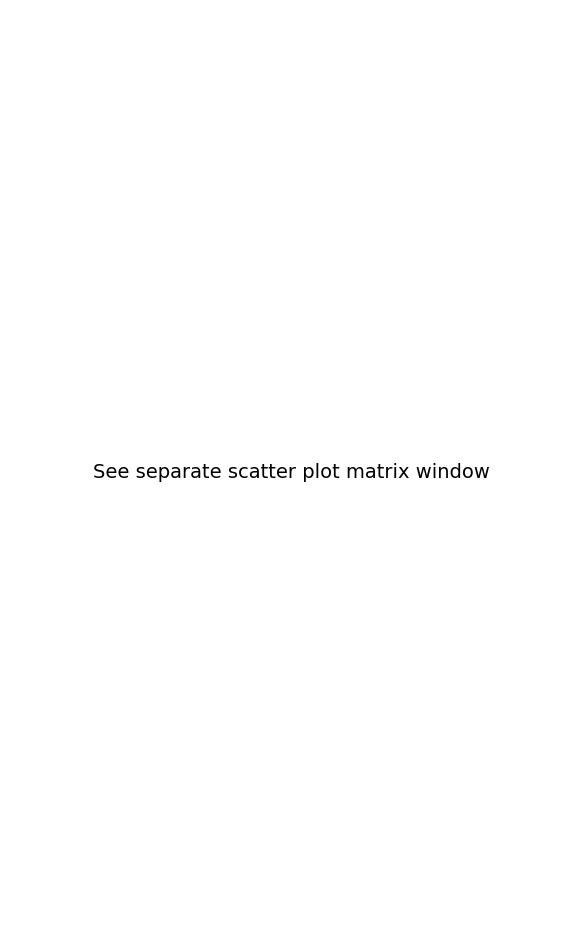

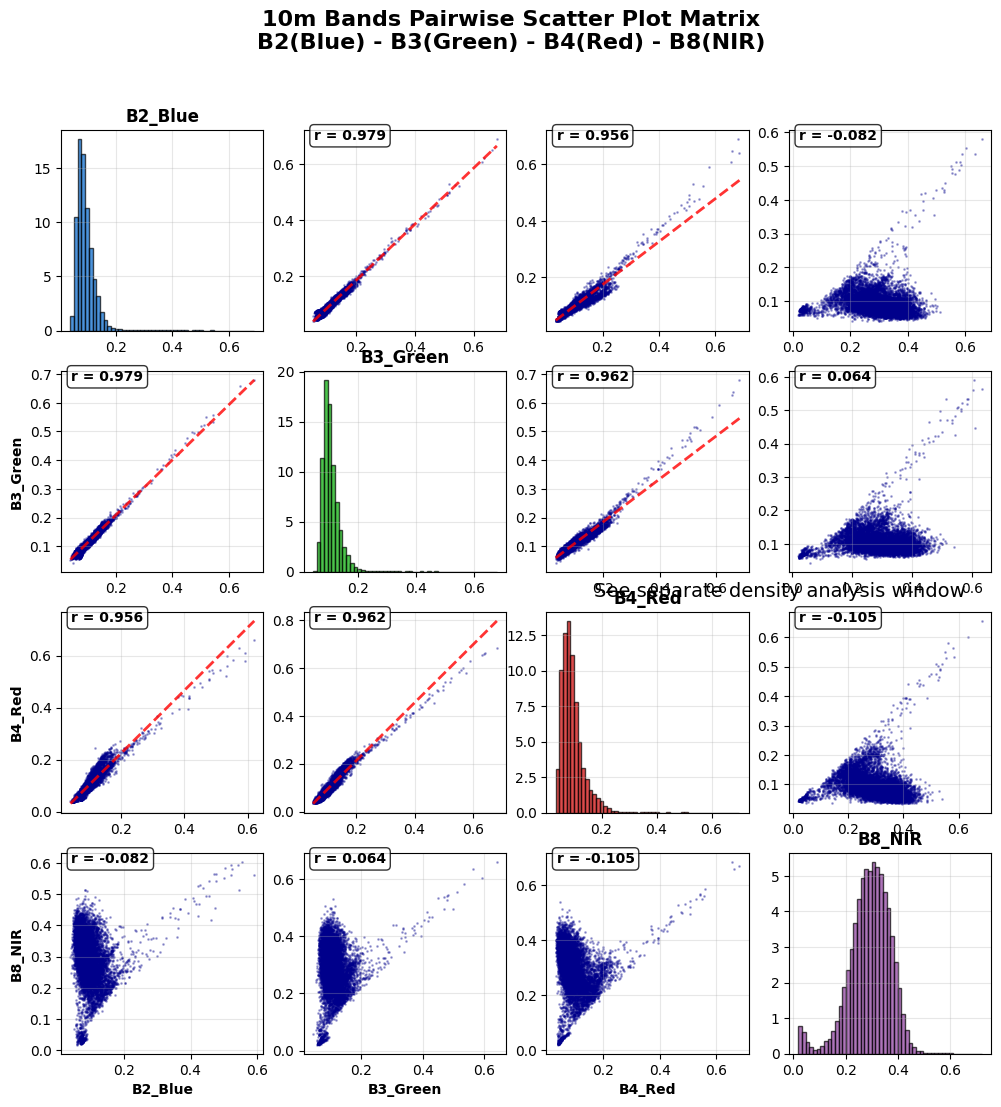

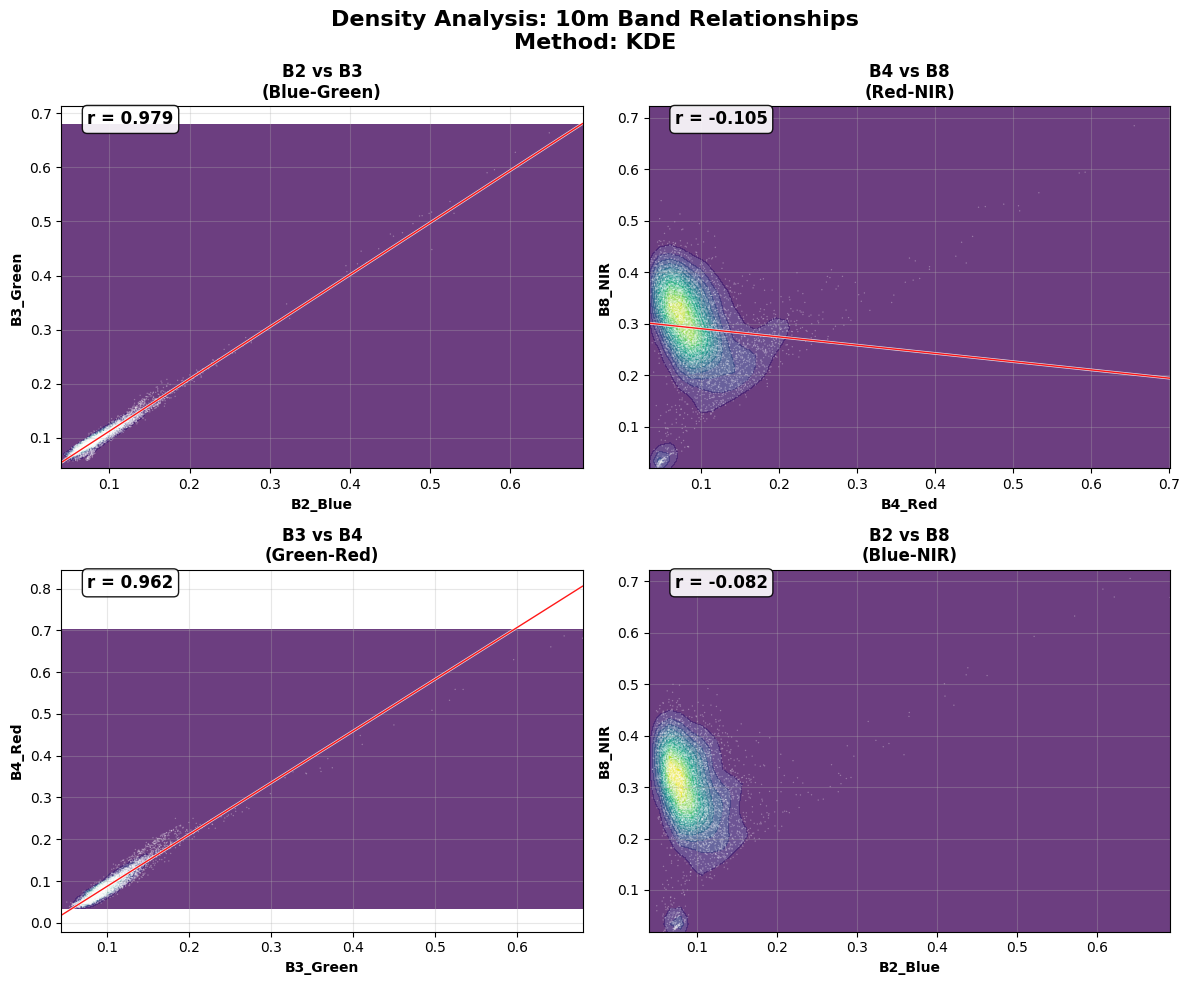


SPECTRAL PATTERN ANALYSIS - 10m BANDS

1. BAND STATISTICS:
--------------------
Band         Mean     Std      Min      Max      Range   
------------------------------------------------------------
B2_Blue      0.093    0.035    0.039    0.754    0.716   
B3_Green     0.105    0.034    0.043    0.748    0.705   
B4_Red       0.094    0.044    0.033    0.773    0.740   
B8_NIR       0.291    0.080    0.019    0.903    0.884   

2. CORRELATION ANALYSIS:
-------------------------
   • B2 Blue vs B3 Green: r = 0.979 (Very Strong)
     → Adjacent visible bands - atmospheric consistency
   • B3 Green vs B4 Red: r = 0.962 (Very Strong)
     → Visible spectrum correlation - chlorophyll absorption
   • B4 Red vs B8 NIR: r = -0.105 (Very Weak)
     → Classical vegetation signature - red edge
   • B2 Blue vs B8 NIR: r = -0.082 (Very Weak)
     → Atmospheric vs vegetation response

3. VEGETATION ANALYSIS (Red-NIR Relationship):
---------------------------------------------
   • NDVI Mean: 0.490


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, pearsonr
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

def correlation_plot(data, no_data_value=0, sample_size=50000, figsize=(16, 12),
                    density_method='kde', alpha_scatter=0.3):


    band_indices = [1, 2, 3, 7]  # 0-indexed: B2=1, B3=2, B4=3, B8=7
    band_names = ['B2_Blue', 'B3_Green', 'B4_Red', 'B8_NIR']
    band_colors = ['#0066CC', '#00AA00', '#CC0000', '#8B3A9C']

    print("Extracting 10-meter bands...")
    print("=" * 40)


    extracted_data = data[:, :, band_indices]
    n_bands = len(band_indices)


    reshaped_data = extracted_data.reshape(-1, n_bands)

    if no_data_value is not None:
        valid_mask = np.all((reshaped_data != no_data_value) &
                           (~np.isnan(reshaped_data)) &
                           (reshaped_data >= 0), axis=1)
    else:
        valid_mask = np.all(~np.isnan(reshaped_data), axis=1)

    valid_data = reshaped_data[valid_mask]

    print(f"Total pixels: {len(reshaped_data):,}")
    print(f"Valid pixels: {len(valid_data):,} ({len(valid_data)/len(reshaped_data)*100:.1f}%)")


    if len(valid_data) > sample_size:
        indices = np.random.choice(len(valid_data), sample_size, replace=False)
        plot_data = valid_data[indices]
        print(f"Sampling {sample_size:,} pixels for visualization")
    else:
        plot_data = valid_data
        print("Using all valid pixels")


    correlation_matrix = np.corrcoef(valid_data.T)


    fig = plt.figure(figsize=figsize)


    n_pairs = (n_bands * (n_bands - 1)) // 2  # Number of unique pairs


    ax1 = plt.subplot(1, 2, 1)
    plot_pairwise_scatter(plot_data, band_names, band_colors, correlation_matrix,
                         ax1, alpha_scatter)


    ax2 = plt.subplot(1, 2, 2)
    plot_density_analysis(plot_data, band_names, correlation_matrix,
                         ax2, density_method)

    plt.tight_layout()


    analysis_results = analyze_spectral_patterns(valid_data, band_names, correlation_matrix)

    return fig, correlation_matrix, analysis_results

def plot_pairwise_scatter(data, band_names, band_colors, corr_matrix, ax, alpha=0.3):

    n_bands = len(band_names)

    
    fig_scatter, axes = plt.subplots(n_bands, n_bands, figsize=(12, 12))

    for i in range(n_bands):
        for j in range(n_bands):
            if i == j:
               
                axes[i, j].hist(data[:, i], bins=50, alpha=0.7,
                               color=band_colors[i], density=True, edgecolor='black')
                axes[i, j].set_title(f'{band_names[i]}', fontweight='bold')
                axes[i, j].grid(True, alpha=0.3)

            else:
               
                sample_indices = np.random.choice(len(data),
                                                 min(10000, len(data)), replace=False)
                x_data = data[sample_indices, j]
                y_data = data[sample_indices, i]

                axes[i, j].scatter(x_data, y_data, alpha=alpha, s=1,
                                  c='darkblue', rasterized=True)

               
                corr = corr_matrix[i, j]
                axes[i, j].text(0.05, 0.95, f'r = {corr:.3f}',
                               transform=axes[i, j].transAxes,
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                               fontsize=10, fontweight='bold')

               
                if abs(corr) > 0.3:
                    z = np.polyfit(x_data, y_data, 1)
                    p = np.poly1d(z)
                    x_trend = np.linspace(np.min(x_data), np.max(x_data), 100)
                    axes[i, j].plot(x_trend, p(x_trend), 'r--', alpha=0.8, linewidth=2)

                axes[i, j].grid(True, alpha=0.3)

               
                if i == n_bands - 1:
                    axes[i, j].set_xlabel(band_names[j], fontweight='bold')
                if j == 0:
                    axes[i, j].set_ylabel(band_names[i], fontweight='bold')

   
    ax.axis('off')
    ax.text(0.5, 0.5, 'See separate scatter plot matrix window',
            ha='center', va='center', fontsize=14,
            transform=ax.transAxes)

    plt.suptitle('10m Bands Pairwise Scatter Plot Matrix\nB2(Blue) - B3(Green) - B4(Red) - B8(NIR)',
                 fontsize=16, fontweight='bold')

    return fig_scatter

def plot_density_analysis(data, band_names, corr_matrix, ax, method='kde'):
    

    
    interesting_pairs = [
        (0, 1, 'B2 vs B3\n(Blue-Green)'),     # Adjacent visible
        (2, 3, 'B4 vs B8\n(Red-NIR)'),        # Vegetation signature
        (1, 2, 'B3 vs B4\n(Green-Red)'),      # Visible correlation
        (0, 3, 'B2 vs B8\n(Blue-NIR)')       # Atmospheric vs vegetation
    ]

    fig_density, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, (i, j, title) in enumerate(interesting_pairs):
        ax_curr = axes[idx]

        x_data = data[:, i]
        y_data = data[:, j]

        if method == 'kde':
           
            xy = np.vstack([x_data, y_data])
            kde = gaussian_kde(xy)

           
            x_min, x_max = np.min(x_data), np.max(x_data)
            y_min, y_max = np.min(y_data), np.max(y_data)

            xx, yy = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            density = kde(positions).reshape(xx.shape)

           
            contour = ax_curr.contourf(xx, yy, density, levels=15, cmap='viridis', alpha=0.8)

            
            sample_indices = np.random.choice(len(data), min(5000, len(data)), replace=False)
            ax_curr.scatter(x_data[sample_indices], y_data[sample_indices],
                           alpha=0.3, s=1, c='white', edgecolors='none')

        elif method == 'hexbin':
           
            hb = ax_curr.hexbin(x_data, y_data, gridsize=30, cmap='viridis', alpha=0.8)

        elif method == 'hist2d':
          
            hist = ax_curr.hist2d(x_data, y_data, bins=50, cmap='viridis', alpha=0.8)

        
        corr = corr_matrix[i, j]
        ax_curr.text(0.05, 0.95, f'r = {corr:.3f}',
                    transform=ax_curr.transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                    fontsize=12, fontweight='bold')

       
        if abs(corr) > 0.1:
            z = np.polyfit(x_data, y_data, 1)
            p = np.poly1d(z)
            x_trend = np.linspace(np.min(x_data), np.max(x_data), 100)
            ax_curr.plot(x_trend, p(x_trend), 'white', linewidth=2, alpha=0.8)
            ax_curr.plot(x_trend, p(x_trend), 'red', linewidth=1, alpha=0.9)

        ax_curr.set_title(title, fontweight='bold', fontsize=12)
        ax_curr.set_xlabel(band_names[i], fontweight='bold')
        ax_curr.set_ylabel(band_names[j], fontweight='bold')
        ax_curr.grid(True, alpha=0.3)

    plt.suptitle(f'Density Analysis: 10m Band Relationships\nMethod: {method.upper()}',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()

   
    ax.axis('off')
    ax.text(0.5, 0.5, 'See separate density analysis window',
            ha='center', va='center', fontsize=14,
            transform=ax.transAxes)

    return fig_density

def analyze_spectral_patterns(data, band_names, corr_matrix):
   

    analysis = {}

    print("\nAnalyzing spectral patterns...")
    print("=" * 35)

    
    analysis['band_stats'] = {}
    for i, band in enumerate(band_names):
        band_data = data[:, i]
        analysis['band_stats'][band] = {
            'mean': np.mean(band_data),
            'std': np.std(band_data),
            'min': np.min(band_data),
            'max': np.max(band_data),
            'range': np.max(band_data) - np.min(band_data)
        }

   
    analysis['correlations'] = {}
    band_pairs = [
        ('B2_Blue', 'B3_Green'),
        ('B3_Green', 'B4_Red'),
        ('B4_Red', 'B8_NIR'),
        ('B2_Blue', 'B8_NIR')
    ]

    for i, (band1, band2) in enumerate(band_pairs):
        idx1 = band_names.index(band1)
        idx2 = band_names.index(band2)
        corr = corr_matrix[idx1, idx2]
        analysis['correlations'][f'{band1}_vs_{band2}'] = corr


    red_data = data[:, band_names.index('B4_Red')]
    nir_data = data[:, band_names.index('B8_NIR')]


    ndvi = (nir_data - red_data) / (nir_data + red_data + 1e-8)
    analysis['ndvi_stats'] = {
        'mean': np.mean(ndvi),
        'std': np.std(ndvi),
        'min': np.min(ndvi),
        'max': np.max(ndvi)
    }

    
    try:
        
        sample_size = min(10000, len(data))
        sample_indices = np.random.choice(len(data), sample_size, replace=False)
        sample_data = data[sample_indices]

       
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(sample_data)

    
        dbscan = DBSCAN(eps=0.3, min_samples=50)
        clusters = dbscan.fit_predict(scaled_data)

        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)

        analysis['clustering'] = {
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_percentage': n_noise / len(clusters) * 100
        }

    except Exception as e:
        analysis['clustering'] = {'error': str(e)}

    return analysis

def print_pattern_analysis(analysis, corr_matrix):
    

    print("\n" + "=" * 80)
    print("SPECTRAL PATTERN ANALYSIS - 10m BANDS")
    print("=" * 80)

    
    print("\n1. BAND STATISTICS:")
    print("-" * 20)
    print(f"{'Band':<12} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'Range':<8}")
    print("-" * 60)

    for band, stats in analysis['band_stats'].items():
        print(f"{band:<12} {stats['mean']:<8.3f} {stats['std']:<8.3f} "
              f"{stats['min']:<8.3f} {stats['max']:<8.3f} {stats['range']:<8.3f}")

    # Correlation analysis
    print(f"\n2. CORRELATION ANALYSIS:")
    print("-" * 25)

    interpretations = {
        'B2_Blue_vs_B3_Green': 'Adjacent visible bands - atmospheric consistency',
        'B3_Green_vs_B4_Red': 'Visible spectrum correlation - chlorophyll absorption',
        'B4_Red_vs_B8_NIR': 'Classical vegetation signature - red edge',
        'B2_Blue_vs_B8_NIR': 'Atmospheric vs vegetation response'
    }

    for pair, corr in analysis['correlations'].items():
        interpretation = interpretations.get(pair, 'General spectral relationship')
        strength = get_correlation_strength(corr)
        print(f"   • {pair.replace('_', ' ')}: r = {corr:.3f} ({strength})")
        print(f"     → {interpretation}")

    
    print(f"\n3. VEGETATION ANALYSIS (Red-NIR Relationship):")
    print("-" * 45)
    ndvi_stats = analysis['ndvi_stats']
    print(f"   • NDVI Mean: {ndvi_stats['mean']:.3f}")
    print(f"   • NDVI Std:  {ndvi_stats['std']:.3f}")
    print(f"   • NDVI Range: [{ndvi_stats['min']:.3f}, {ndvi_stats['max']:.3f}]")

    if ndvi_stats['mean'] > 0.3:
        print("   → Strong vegetation signature detected")
    elif ndvi_stats['mean'] > 0.1:
        print("   → Moderate vegetation presence")
    else:
        print("   → Limited vegetation or urban-dominated landscape")

    
    print(f"\n4. SPECTRAL CLUSTERING:")
    print("-" * 22)

    if 'error' in analysis['clustering']:
        print(f"   • Clustering failed: {analysis['clustering']['error']}")
    else:
        clustering = analysis['clustering']
        print(f"   • Number of clusters: {clustering['n_clusters']}")
        print(f"   • Noise points: {clustering['n_noise']} ({clustering['noise_percentage']:.1f}%)")

        if clustering['n_clusters'] > 1:
            print("   → Multiple distinct spectral classes detected")
            print("   → Indicates landscape heterogeneity")
        else:
            print("   → Homogeneous spectral response")

   
    print(f"\n5. OBSERVED PATTERNS:")
    print("-" * 20)

   
    red_nir_corr = analysis['correlations']['B4_Red_vs_B8_NIR']
    if red_nir_corr < -0.3:
        print("   • Strong inverse Red-NIR correlation → Healthy vegetation present")
    elif red_nir_corr < 0:
        print("   • Weak inverse Red-NIR correlation → Mixed vegetation/urban")
    else:
        print("   • Positive Red-NIR correlation → Urban/bare soil dominated")

   
    vis_corr = analysis['correlations']['B2_Blue_vs_B3_Green']
    if vis_corr > 0.8:
        print("   • High visible band correlation → Consistent atmospheric conditions")
    else:
        print("   • Moderate visible correlation → Variable atmospheric effects")

   
    if ndvi_stats['std'] > 0.2:
        print("   • High NDVI variability → Diverse vegetation conditions")
    else:
        print("   • Low NDVI variability → Uniform landscape")

def get_correlation_strength(r):

    abs_r = abs(r)
    if abs_r >= 0.8:
        return "Very Strong"
    elif abs_r >= 0.6:
        return "Strong"
    elif abs_r >= 0.4:
        return "Moderate"
    elif abs_r >= 0.2:
        return "Weak"
    else:
        return "Very Weak"


if __name__ == "__main__":

    print("Demonstrating 10m band correlation analysis...")

   
    data = np.load('sentinel2_rochester.npy')
    print("Creating correlation and density plots...")

   
    fig, corr_matrix, analysis = correlation_plot(data,
                                                 no_data_value=0,
                                                 sample_size=30000,
                                                 density_method='kde')

    plt.show()

   
    print_pattern_analysis(analysis, corr_matrix)

    print(f"\nAnalysis complete!")
    print(f"Correlation matrix:\n{corr_matrix}")

EXPLANATION
Prior to computing Pearson correlation coefficients across all valid pixel locations, this script handles no-data by removing pixels with values of 0, NaN, or negative numbers. It then computes and analyzes the correlation matrix between all 12 Sentinel-2 spectral bands to understand their inter-relationships.  In addition to performing in-depth statistical analysis to find highly correlated band pairs (|r| ≥ 0.8), weakly correlated pairs (|r| ≤ 0.3), and negative correlations, the code generates a thorough heatmap visualization of the correlation matrix and looks at correlations within spectral regions (visible, red-edge, NIR, SWIR).

part 2 - Before calculating correlations and producing visualizations, this script handles no-data by removing pixels with values of 0, NaN, or negative numbers. It then conducts a thorough correlation analysis, focusing on the four 10-meter resolution Sentinel-2 bands (Blue, Green, Red, and NIR).  The code computes important spectral indices such as the Normalized Difference Vegetation Index (NDVI) from the Red-NIR relationship, creates detailed scatter plot matrices and density plots to visualize relationships between band pairs, and uses clustering analysis to pinpoint different spectral classes in the landscape.